In [2]:
from ast import literal_eval
import os

import logging
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import pandas as pd
import torch

from src.object_detector.custom_image_dataset_object_detector import CustomImageDataset

In [3]:
# define configurations for training run
RUN = 0
PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.08
PERCENTAGE_OF_VAL_SET_TO_USE = 0.1
BATCH_SIZE = 32
NUM_WORKERS = 12
EPOCHS = 30
LR = 1e-2
EVALUATE_EVERY_K_STEPS = 3500  # how often to evaluate the model on the validation set and log metrics to tensorboard (additionally, model will always be evaluated at end of epoch)
PATIENCE = 10  # number of evaluations to wait before early stopping
PATIENCE_LR_SCHEDULER = 3  # number of evaluations to wait for val loss to reduce before lr is reduced by 1e-1


In [4]:
def get_datasets_as_dfs():
    path_dataset_object_detector = "/u/home/tanida/datasets/dataset-for-full-model-50"

    usecols = ["mimic_image_file_path", "bbox_coordinates", "bbox_labels"]

    # since bbox_coordinates and labels are stored as strings in the csv_file, we have to apply 
    # the literal_eval func to convert them to python lists
    converters = {"bbox_coordinates": literal_eval, "bbox_labels": literal_eval}

    datasets_as_dfs = {dataset: os.path.join(path_dataset_object_detector, f"{dataset}-50") + ".csv" for dataset in ["train", "valid", "test"]}
    datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, converters=converters) for dataset, csv_file_path in datasets_as_dfs.items()}

    total_num_samples_train = len(datasets_as_dfs["train"])
    total_num_samples_val = len(datasets_as_dfs["valid"])

    # compute new number of samples for both train and val
    new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)
    new_num_samples_val = int(PERCENTAGE_OF_VAL_SET_TO_USE * total_num_samples_val)

    # limit the datasets to those new numbers
    datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]
    datasets_as_dfs["valid"] = datasets_as_dfs["valid"][:new_num_samples_val]

    return datasets_as_dfs


In [5]:
datasets_as_dfs = get_datasets_as_dfs()

In [6]:
def get_transforms(dataset: str):
    # see compute_mean_std_dataset.py in src/dataset_bounding_boxes
    mean = 0.471
    std = 0.302

    # note: transforms are applied to the already resized (to 224x224) and padded images 
    # (see __getitem__ method of custom dataset class)!

    # use albumentations for Compose and transforms
    train_transforms = A.Compose([
        # optionally add augmentation transforms here (but bboxes also have to be transformed in this case!)
        # A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    # don't apply data augmentations to val and test set
    val_test_transforms = A.Compose(
        [
            # A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )

    if dataset == "train":
        return train_transforms
    else:
        return val_test_transforms



In [7]:
train_transforms = get_transforms("train")
val_transforms = get_transforms("val")

In [8]:
train_dataset = CustomImageDataset(datasets_as_dfs["train"], train_transforms)
val_dataset = CustomImageDataset(datasets_as_dfs["valid"], val_transforms)

In [10]:
import pandas as pd
import numpy as np
import os, re 
import time
from numpy import genfromtxt
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)
%matplotlib inline

3.5.2


In [9]:
from src.dataset_bounding_boxes.constants import ANATOMICAL_REGIONS

In [10]:
def checkCoord(x,dim):
    if x < 0:
        x = 0
    if x > dim:
        x = dim
    return x

# Draw bbox on image -- has the option to save image with not margin for annotation
def drawBbox(image, x1, y1, x2, y2, bbox_name=None, phrases=None, plot=True,exportfilepath=None):
    image = image.copy()
    stroke = 10
    w,h = image.shape
    x1 = checkCoord(int(x1), w)
    y1 = checkCoord(int(y1), h)
    x2 = checkCoord(int(x2), w)
    y2 = checkCoord(int(y2), h)
    image[y1:y1 + stroke, x1:x2] = 3
    image[y2:y2 + stroke, x1:x2] = 3
    image[y1:y2, x1:x1 + stroke] = 3
    image[y1:y2, x2:x2 + stroke] = 3
    
    if plot:
        dpi = 3000
        # What size does the figure need to be in inches to fit the image?
        height, width = image.shape
        figsize = width / float(dpi), height / float(dpi)
        figsize = width / 30., height / 30.
        # To make a figure without the frame :
#         fig = plt.figure(frameon=False) # gives a bug in the plt 3.1.0 + this jupyter notebook env for some reason
        fig = plt.figure()
        fig.set_size_inches(figsize)
        # To make the content fill the whole figure
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        
        if bbox_name:
            ax.set_title(bbox_name)
            
        if phrases:
            fig.text(.5, .05, phrases, ha='center')

        # Then draw your image on it :
        ax.imshow(image, cmap='gray', aspect='auto', interpolation='nearest')

        # Ensure we're displaying with square pixels and the right extent.
        # This is optional if you haven't called `plot` or anything else that might
        # change the limits/aspect.
        ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect='auto')
        
    if exportfilepath!=None:
        fig.savefig(exportfilepath, dpi=dpi, transparent=True)
        
#     if plot:
#         plt.figure(figsize=(10, 10))
#         plt.imshow(image, cmap='gray')
#         # plt.close() #or won't show up in notebook if run
#     if exportfilepath!=None:
#         fig.savefig(exportfilepath, dpi=80, transparent=True)
    return image


# visualize an object given image_id and name
def plot_object(image, bboxes, labels, index):
    bbox = bboxes[index]
    class_label = labels[index]

    for region_name, id in ANATOMICAL_REGIONS.items():
        if (class_label-1) == id:
            bbox_name = region_name

    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]

    drawBbox(image, x1, y1, x2, y2, bbox_name, None)

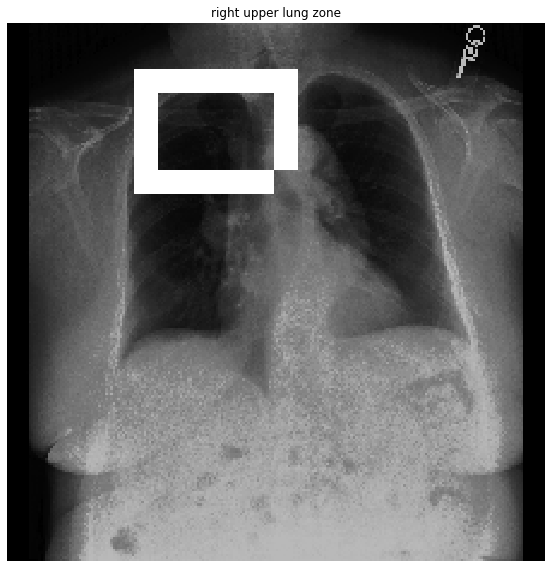

In [39]:
plot_object(single_image.squeeze().numpy(), bboxes, labels, 1)

In [11]:
from object_detector import ObjectDetector

In [12]:
model = ObjectDetector(return_feature_vectors=False)
path_to_best_object_detector_weights = "/u/home/tanida/runs/object_detector/run_0/weights/last_epoch.pth"
model.load_state_dict(torch.load(path_to_best_object_detector_weights))

<All keys matched successfully>

In [13]:
model.eval()

ObjectDetector(
  (backbone): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [14]:
first_image = train_dataset[0]["image"]
second_image = train_dataset[1]["image"]
third_image = train_dataset[2]["image"]
fourth_image = train_dataset[3]["image"]

In [16]:
batch = torch.stack([first_image, second_image, third_image, fourth_image], dim=0)
losses, detections, class_predicted = model(batch)

In [18]:
print(detections["top_region_boxes"].shape)
print(detections["top_scores"].shape)

torch.Size([4, 36, 4])
torch.Size([4, 36])


In [23]:
first_image_boxes = train_dataset[0]["boxes"]
second_image_boxes = train_dataset[1]["boxes"]
third_image_boxes = train_dataset[2]["boxes"]
fourth_image_boxes = train_dataset[3]["boxes"]

In [24]:
first_image_boxes.shape

torch.Size([36, 4])

In [21]:
first_image_pred_boxes = detections["top_region_boxes"][0, ...]
first_image_pred_boxes.shape

torch.Size([36, 4])

In [28]:
first_6_pred_boxes = torch.split(first_image_boxes, 6)[0]
first_6_gt_boxes = torch.split(first_image_pred_boxes, 6)[0]
first_6_pred_boxes.shape

torch.Size([6, 4])

In [30]:
first_6_pred_boxes

tensor([[ 33.,  16.,  97., 153.],
        [ 53.,  19., 111.,  61.],
        [ 46.,  61.,  97.,  94.],
        [ 33.,  94., 102., 153.],
        [ 88.,  54.,  97., 100.],
        [ 62.,  16., 110.,  40.]])

In [33]:
for pred_box in first_6_pred_boxes:
    x0, y0, x1, y1 = pred_box.tolist()
    print(x0, y0, x1, y1)

33.0 16.0 97.0 153.0
53.0 19.0 111.0 61.0
46.0 61.0 97.0 94.0
33.0 94.0 102.0 153.0
88.0 54.0 97.0 100.0
62.0 16.0 110.0 40.0


In [113]:
class_predicted[0].tolist()

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

Text(0.5, 1.0, 'right atrium, descending aorta, left cardiac silhouette (np)\nupper mediastinum, right cardiac silhouette, abdomen (np)')

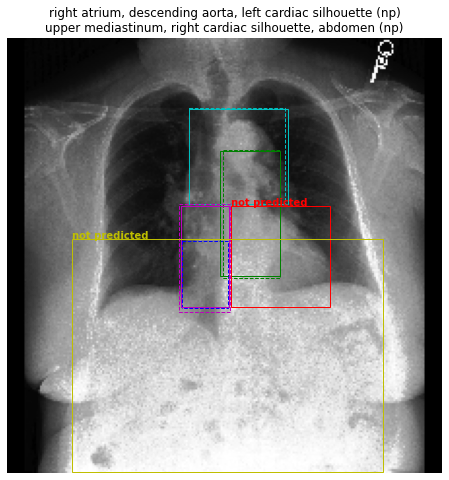

In [112]:
import matplotlib.pyplot as plt

def get_title(region_set, class_preds):
    # region_set always contains 6 region names
    # add a line break to the title, as to not make it too long
    # add "(np)" after region if it was not predicted
    region_set = [region if cls_pred else region + " (np)" for region, cls_pred in zip(region_set, class_preds)]
    return ", ".join(region_set[:3]) + "\n" + ", ".join(region_set[3:])

def plot_box(box, ax, clr, linestyle, class_pred=True):
    x0, y0, x1, y1 = box.tolist()
    h = y1 - y0
    w = x1 - x0
    ax.add_artist(
      plt.Rectangle(
          xy=(x0, y0),
          height=h,
          width=w,
          fill=False,
          color=clr,
          linewidth=1,
          linestyle=linestyle
      )
    )
    
    # add an annotation to the gt box, that the pred box does not exist
    if not class_pred:
        ax.annotate("not predicted", (x0, y0), color=clr, weight="bold", fontsize=10)

regions_to_plot = region_set_6

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
# fig, ax = plt.subplots(1, figsize=(8, 8))
plt.imshow(first_image.cpu().numpy().transpose(1, 2, 0), cmap='gray')
plt.axis('off')
colors = ["b", "g", "r", "c", "m", "y"]
class_preds = [True, True, False, True, True, False]
for region, color, cls_pred in zip(regions_to_plot, colors, class_preds):
    region_index = ANATOMICAL_REGIONS[region]

    box_gt = first_image_boxes[region_index]
    plot_box(box_gt, ax, clr=color, linestyle="solid", class_pred=cls_pred)

    if cls_pred:
        box_pred = first_image_pred_boxes[region_index]
        plot_box(box_pred, ax, clr=color, linestyle="dashed")

title = get_title(regions_to_plot, class_preds)
ax.set_title(title)

In [87]:
from src.dataset_bounding_boxes.constants import ANATOMICAL_REGIONS
region_set_1 = ["right lung", "right costophrenic angle", "left lung", "left costophrenic angle", "cardiac silhouette", "spine"]
region_set_2 = ["right upper lung zone", "right mid lung zone", "right lower lung zone", "left upper lung zone", "left mid lung zone", "left lower lung zone"]
region_set_3 = ["right hilar structures", "right apical zone", "right cardiophrenic angle", "left hilar structures", "left apical zone", "left cardiophrenic angle"]
region_set_4 = ["right hemidiaphragm", "left hemidiaphragm", "trachea", "right clavicle", "left clavicle", "aortic arch"]
region_set_5 = ["mediastinum", "left upper abdomen", "right upper abdomen", "svc", "cavoatrial junction", "carina"]
region_set_6 = ["right atrium", "descending aorta", "left cardiac silhouette", "upper mediastinum", "right cardiac silhouette", "abdomen"] 

In [86]:
all_regions = set()
all_region_sets = [region_set_1, region_set_2, region_set_3, region_set_4, region_set_5, region_set_6]

for region_set in all_region_sets:
    for reg in region_set:
        all_regions.add(reg)

print(len(all_regions))

36
